In [1]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

In [2]:
# !pip install -r requirements.txt -q
# !pip install ipython-autotime -q
# !pip install tensorflow-addons -q

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

2024-11-21 13:59:01.315045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 13:59:01.315126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 13:59:01.317278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 13:59:01.330759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 13:59:03.111785: W tensorflow/compiler/tf2

tensorflow version: 2.15.0
Num GPUs Available:  1


2024-11-21 13:59:05.658534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 13:59:05.701724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 13:59:05.702077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

time: 88.6 ms (started: 2024-11-21 13:59:05 +00:00)


In [4]:
# parameter
# n_steps_in: Number of input time steps
# n_steps_out: Number of days to predict ahead

n_steps_in = 14  
n_steps_out = 5
epochs = 200
batch_size = 64

time: 763 µs (started: 2024-11-21 13:59:05 +00:00)


In [5]:
def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data('processed_data')
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,SMA7,SMA14,...,EMA7,EMA25,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-19 00:00:00+00:00,25.937435,28.752501,29.129999,28.670000,29.025000,193146000,38.868505,-58.647164,28.875357,29.083214,...,29.011843,29.811806,30.819353,30.361521,-0.639367,-59.662038,30.115768,28.050661,8.949397,28.162500
2015-08-20 00:00:00+00:00,25.405201,28.162500,28.587500,27.907499,28.520000,274006400,34.842467,-76.661486,28.845357,28.928750,...,28.799508,29.684936,30.766216,30.339640,-0.675706,-101.719165,29.807586,28.049914,8.822285,26.440001
2015-08-21 00:00:00+00:00,23.851353,26.440001,27.975000,26.412500,27.607500,513102000,26.282999,-99.232910,28.506786,28.702321,...,28.209631,29.435326,30.679692,30.300837,-0.833884,-193.641185,30.187027,27.217616,8.940749,25.780001
2015-08-24 00:00:00+00:00,23.255964,25.780001,27.200001,23.000000,23.717501,648825200,23.863926,-60.271513,28.077143,28.496607,...,27.602223,29.154147,30.581698,30.255854,-1.000959,-286.791374,30.611922,26.381293,9.012688,25.934999
2015-08-25 00:00:00+00:00,23.395788,25.934999,27.777500,25.875000,27.777500,414406400,25.595895,-58.056453,27.640715,28.288393,...,27.185417,28.906520,30.488764,30.212860,-1.108087,-175.033141,30.766350,25.810436,9.087065,27.422501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,233.175714,231.504286,...,232.117849,229.678046,219.220789,207.361942,2.040117,34.671127,237.405189,225.603382,1.664750,233.399994
2024-10-28 00:00:00+00:00,233.143494,233.399994,234.729996,232.550003,233.320007,36087100,56.742652,-32.306559,233.354285,232.049285,...,232.438385,229.964350,219.504373,207.621027,2.033819,76.852796,237.075664,227.022906,1.484857,233.669998


time: 167 ms (started: 2024-11-21 13:59:05 +00:00)


In [6]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(train_features, train_targets, n_steps_in, n_steps_out)
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(val_features, val_targets, n_steps_in, n_steps_out)
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(values_list, n_steps_in, n_steps_out, train_split=0.8)

Training shapes: X=(34865, 14, 20), y=(34865, 5)
Validation shapes: X=(8474, 14, 20), y=(8474, 5)
Number of features: 20
time: 231 ms (started: 2024-11-21 13:59:05 +00:00)


# training

In [7]:
import tensorflow_addons as tfa

# Cyclical learning rate
# steps_per_epoch = len(train_X) // batch_size
# n = 2
# cycle = 12
# epochs = cycle * n * 2
# print(epochs)

# clr = tfa.optimizers.TriangularCyclicalLearningRate(
#     initial_learning_rate=1e-4,
#     maximal_learning_rate=1e-2,
#     step_size = n * steps_per_epoch)

def create_lstm_model(n_steps_in, n_features, n_steps_out):
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(25, activation='leaky_relu', dropout=0.025, input_shape=(n_steps_in, n_features)),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss = ['mae']
    model.compile(optimizer=optimizer, loss_weights=[100], loss=loss)
    model.summary()
    
    return model

# Create and train model
model = create_lstm_model(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-11-21 13:59:06.266508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 13:59:06.266830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative va

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 5)                 130       
                                                                 
Total params: 4730 (18.48 KB)
Trainable params: 4730 (18.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 3.7 s (started: 2024-11-21 13:59:06 +00:00)


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/200


2024-11-21 13:59:15.677914: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efe0c012a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-21 13:59:15.677974: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-11-21 13:59:15.689115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 13:59:16.819878: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1732197557.016030    3660 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 - 24s - loss: 5.6584 - val_loss: 2.4967 - 24s/epoch - 44ms/step
Epoch 2/200
545/545 - 16s - loss: 1.8604 - val_loss: 1.6877 - 16s/epoch - 30ms/step
Epoch 3/200
545/545 - 16s - loss: 1.4417 - val_loss: 1.4364 - 16s/epoch - 30ms/step
Epoch 4/200
545/545 - 16s - loss: 1.2609 - val_loss: 1.3363 - 16s/epoch - 29ms/step
Epoch 5/200
545/545 - 15s - loss: 1.1669 - val_loss: 1.2865 - 15s/epoch - 28ms/step
Epoch 6/200
545/545 - 15s - loss: 1.1073 - val_loss: 1.2250 - 15s/epoch - 27ms/step
Epoch 7/200
545/545 - 16s - loss: 1.0439 - val_loss: 1.1964 - 16s/epoch - 30ms/step
Epoch 8/200
545/545 - 17s - loss: 1.0091 - val_loss: 1.1926 - 17s/epoch - 30ms/step
Epoch 9/200
545/545 - 16s - loss: 0.9693 - val_loss: 1.1775 - 16s/epoch - 29ms/step
Epoch 10/200
545/545 - 17s - loss: 0.9441 - val_loss: 1.1432 - 17s/epoch - 31ms/step
Epoch 11/200
545/545 - 16s - loss: 0.9195 - val_loss: 1.1420 - 16s/epoch - 29ms/step
Epoch 12/200
545/545 - 15s - loss: 0.8957 - val_loss: 1.1210 - 15s/epoch - 27ms/step
E

In [9]:
# Make predictions
y_pred = model.predict(val_X)
print(y_pred.shape)

# Evaluate for each time step
for i in range(n_steps_out):
    mse = mean_squared_error(val_y[:, i], y_pred[:, i])
    print(f"MSE for step {i+1}: {mse: .4f}")

265/265 [==============================] - 2s 8ms/step
(8474, 5)
MSE for step 1:  0.0003
MSE for step 2:  0.0002
MSE for step 3:  0.0002
MSE for step 4:  0.0003
MSE for step 5:  0.0003
time: 2.87 s (started: 2024-11-21 14:09:37 +00:00)


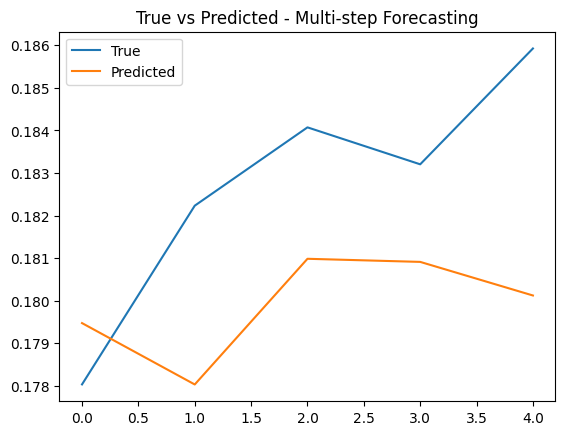

time: 398 ms (started: 2024-11-21 14:09:40 +00:00)


In [10]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

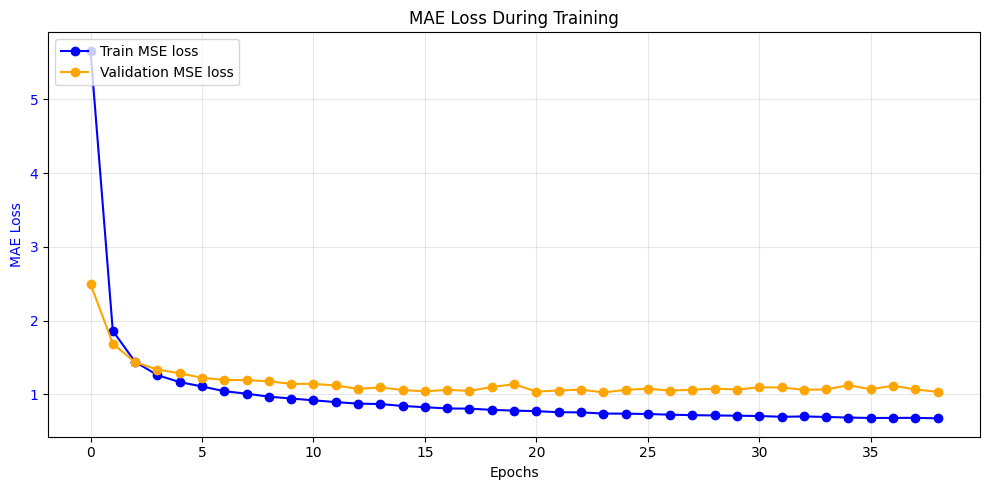

time: 379 ms (started: 2024-11-21 14:09:40 +00:00)


In [11]:
# Plotting
fig1, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MSE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MSE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
plt.grid(True, alpha=0.3)
ax1.set_title('MAE Loss During Training')

# RMSE plot (shared x-axis, different y-axis)
# ax2 = ax1.twinx()
# fig2, ax2 = plt.subplots(figsize=(10, 5))
# ax2.plot(epoch_range, history.history["unscaled_mse"], label='Train MSE', color='green')
# ax2.plot(epoch_range, history.history["val_unscaled_mse"], label='Validation MSE', color='red')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
# ax2.tick_params(axis='y', labelcolor='green')
# ax2.legend(loc='upper left')
# plt.grid(True, alpha=0.3)
# ax2.set_title('RMSE During Training')

plt.tight_layout()
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 25.5714
RMSE: 5.0568
MAE: 4.1031


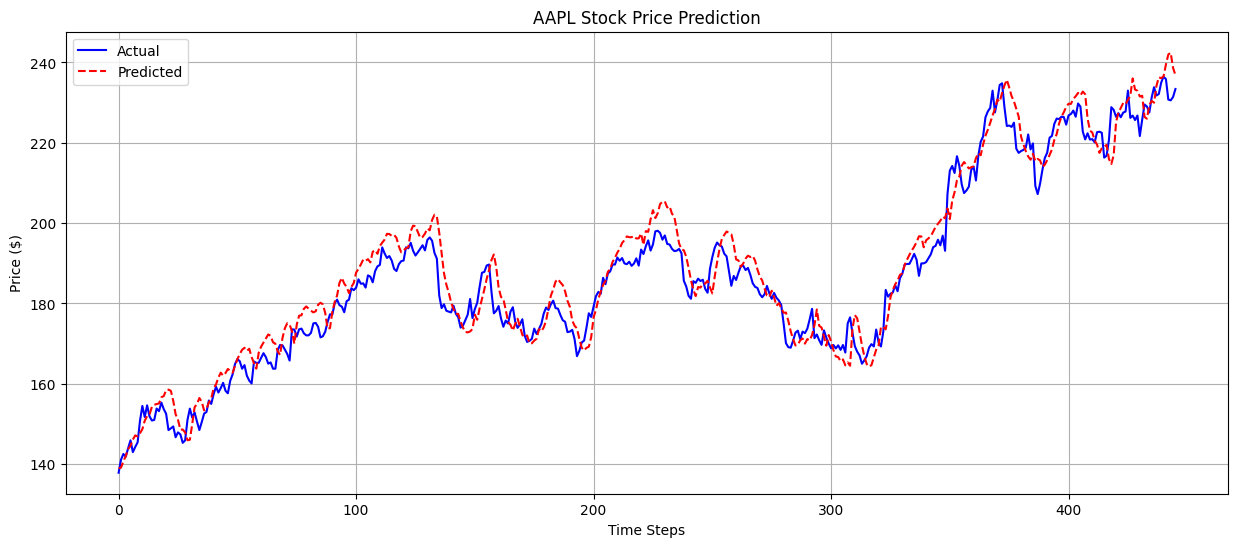


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 20.5247
RMSE: 4.5304
MAE: 3.5374


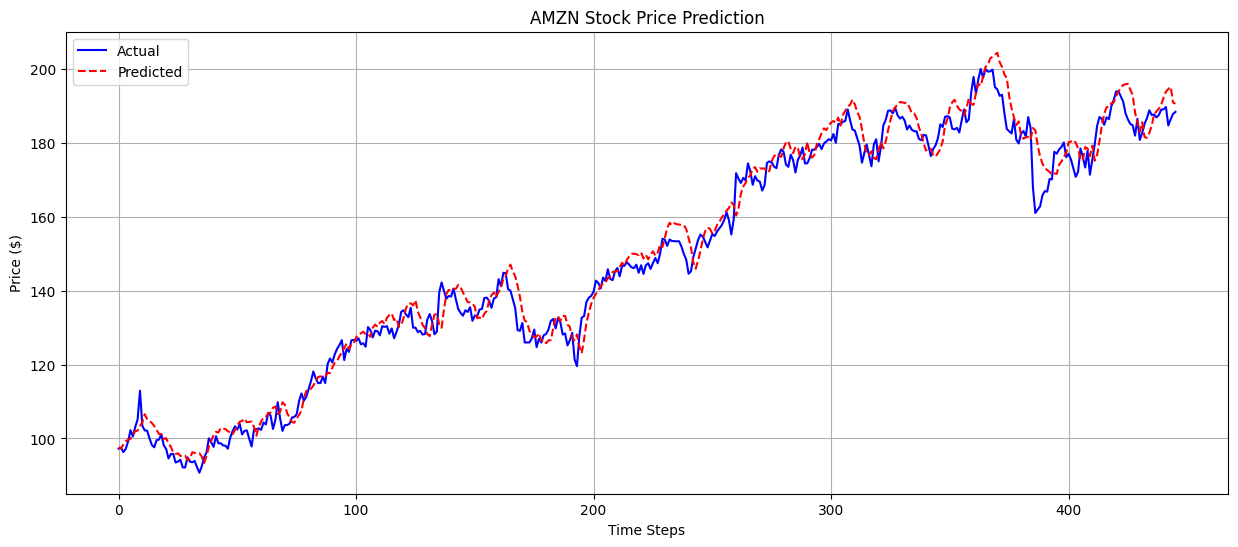


Analyzing GME...

Evaluation Metrics for GME:
MSE: 9.2180
RMSE: 3.0361
MAE: 1.9189


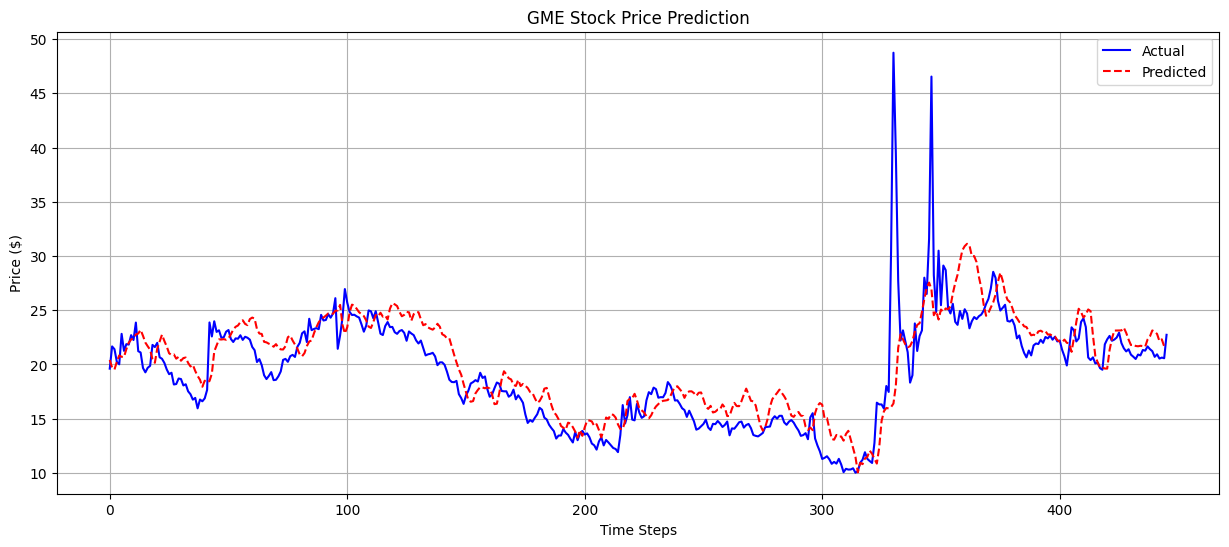


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 16.2775
RMSE: 4.0345
MAE: 3.1130


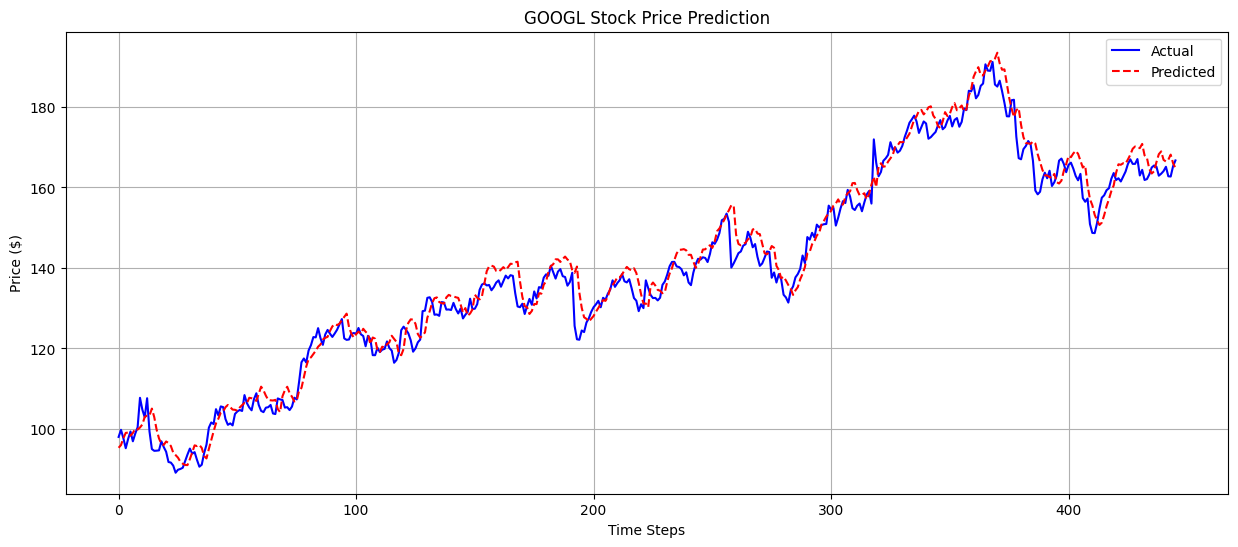


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 1306.3540
RMSE: 36.1435
MAE: 29.3199


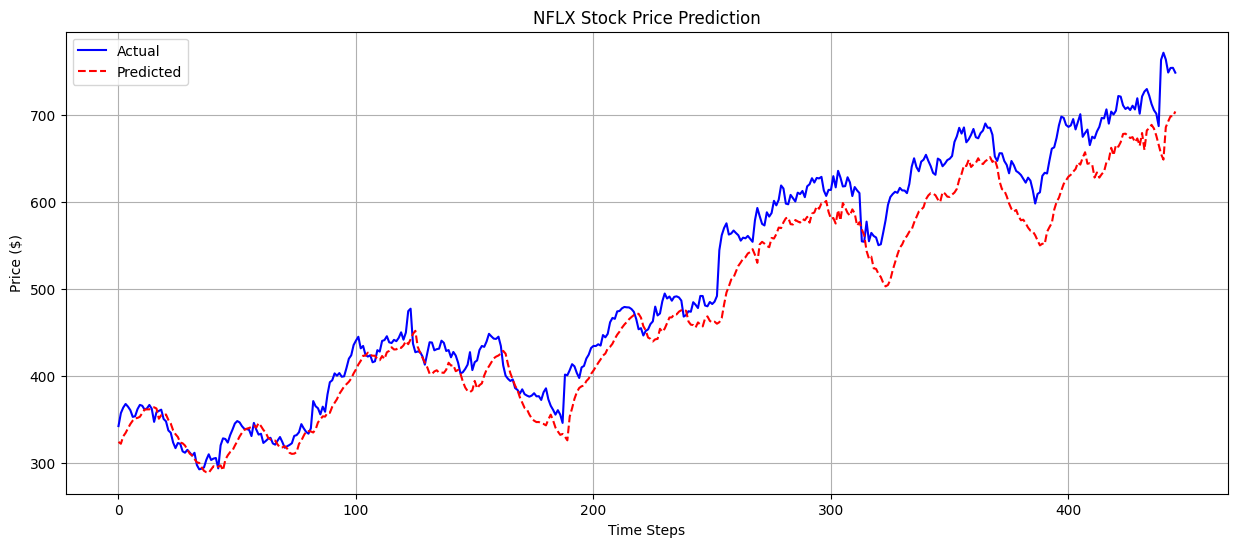


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 190.8928
RMSE: 13.8164
MAE: 10.4546


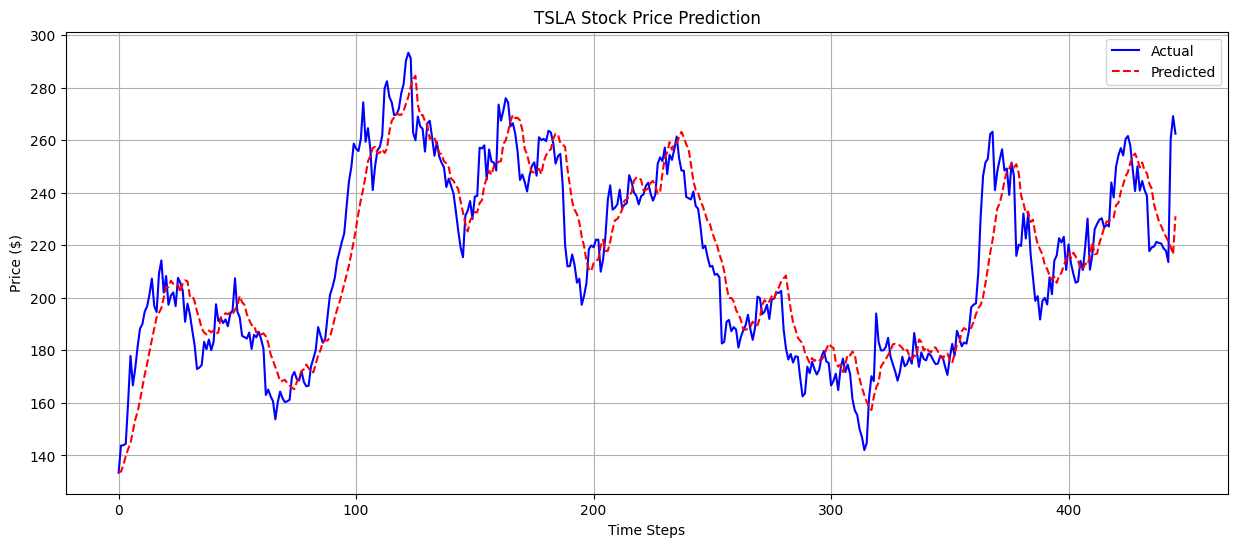


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 150.5094
RMSE: 12.2682
MAE: 9.5716


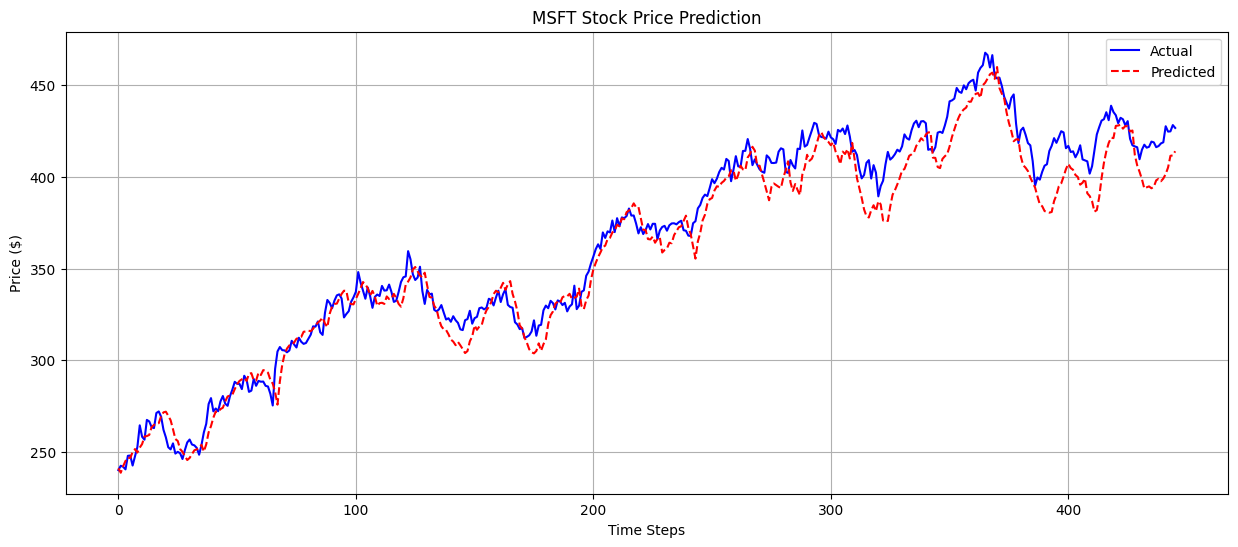


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 18.3962
RMSE: 4.2891
MAE: 2.9737


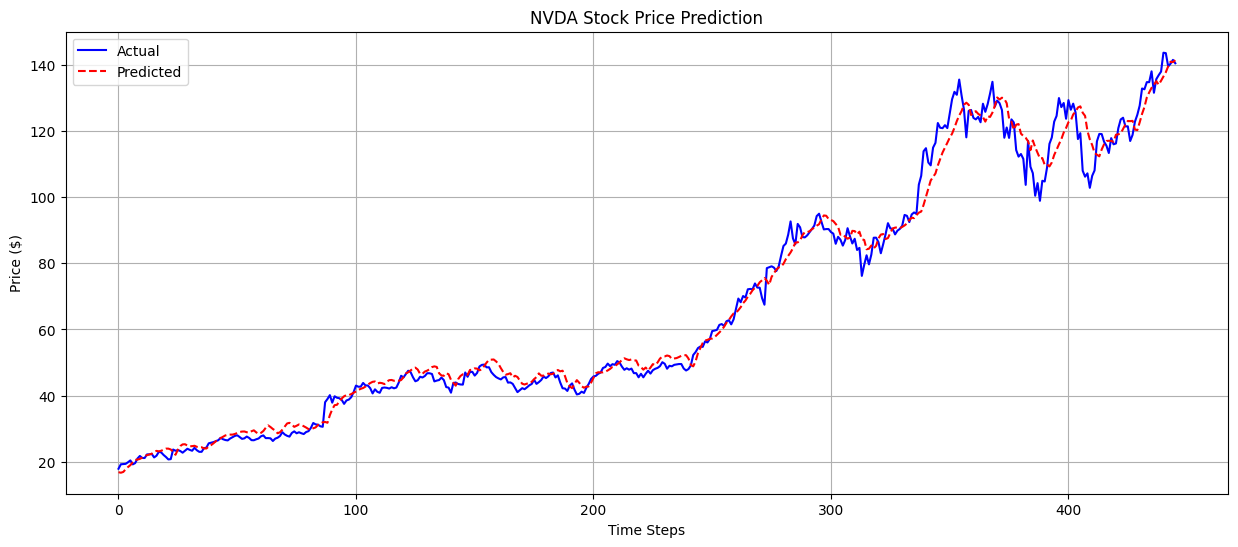


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 50.2334
RMSE: 7.0876
MAE: 5.2587


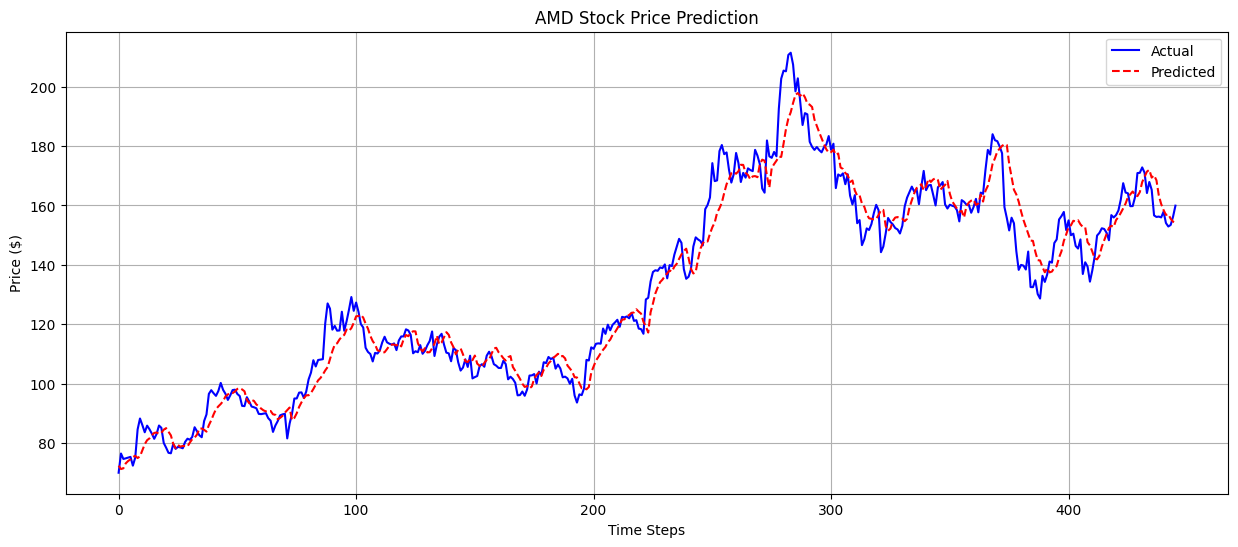


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 58.4732
RMSE: 7.6468
MAE: 5.6109


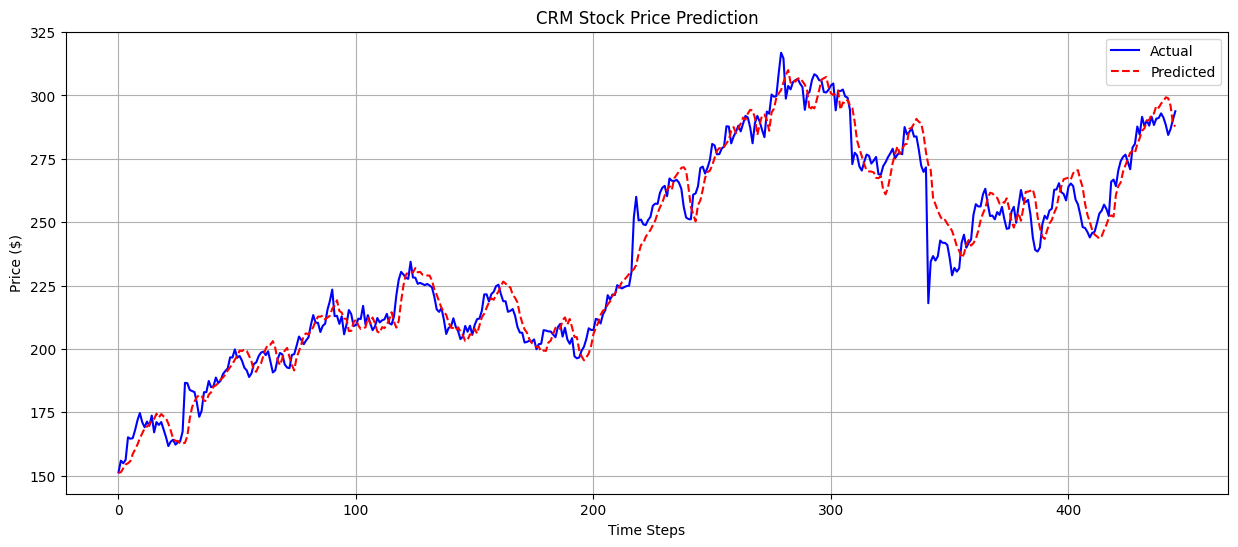


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 21.4605
RMSE: 4.6325
MAE: 3.7609


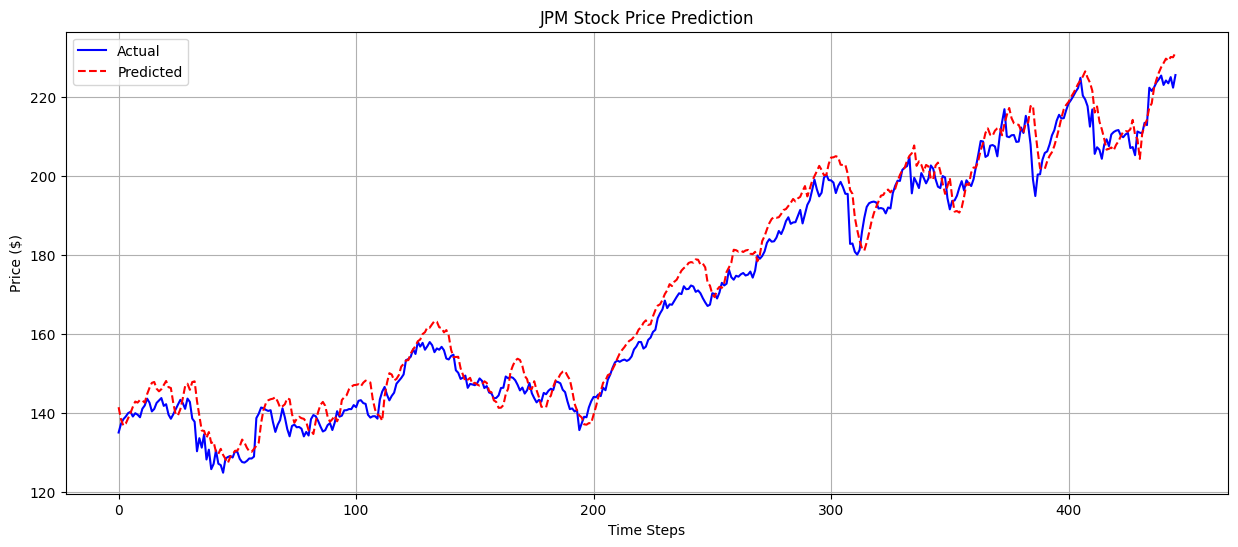


Analyzing V...

Evaluation Metrics for V:
MSE: 44.4915
RMSE: 6.6702
MAE: 5.5696


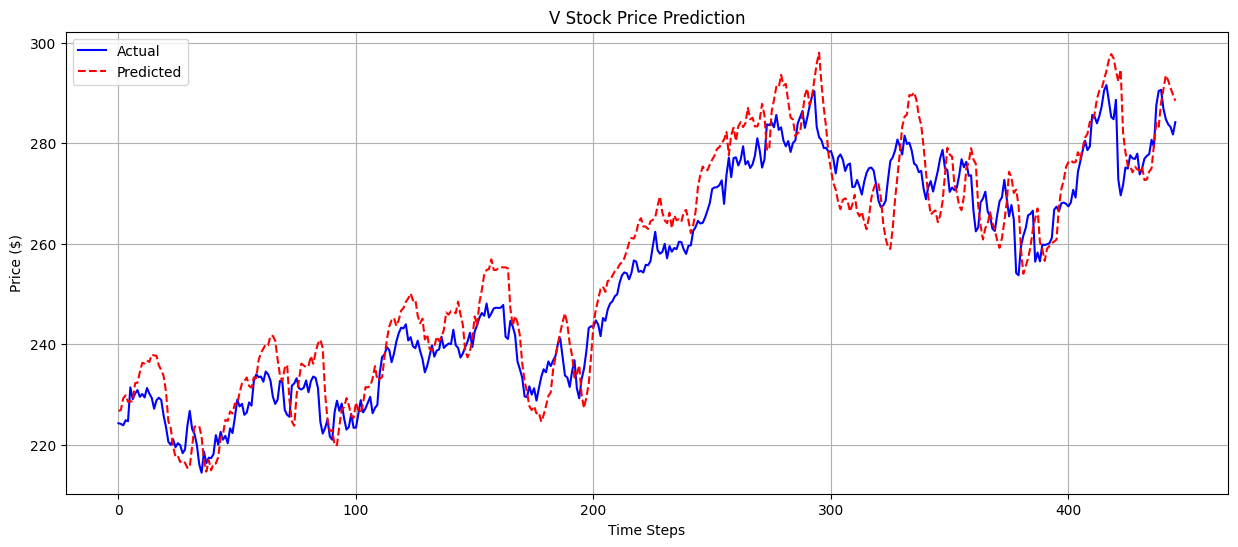


Analyzing MA...

Evaluation Metrics for MA:
MSE: 235.2076
RMSE: 15.3365
MAE: 12.2956


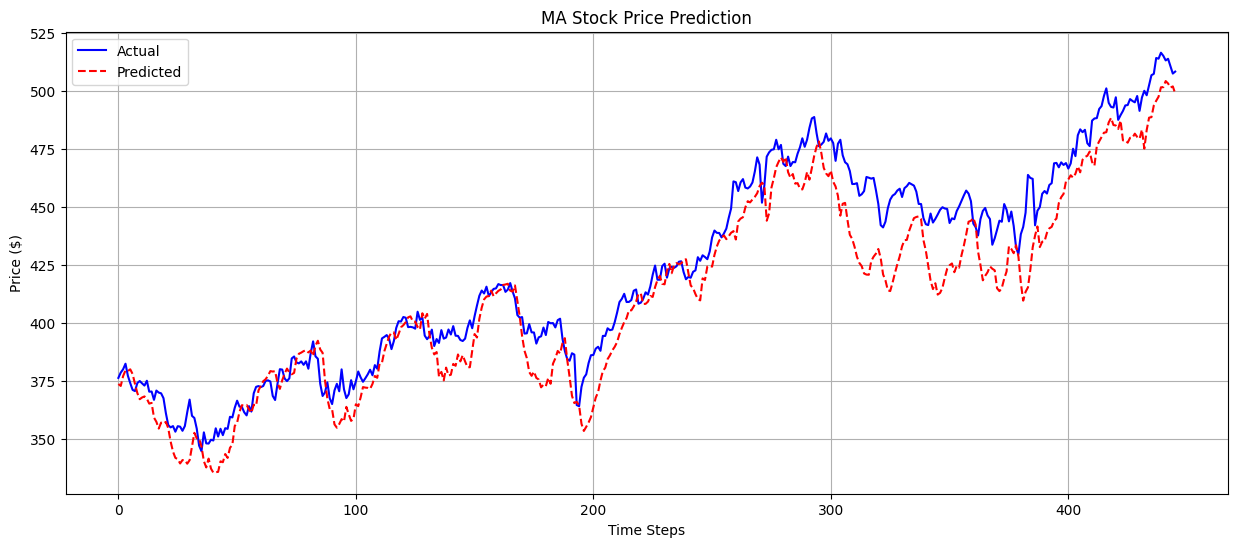


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 186.5382
RMSE: 13.6579
MAE: 7.8131


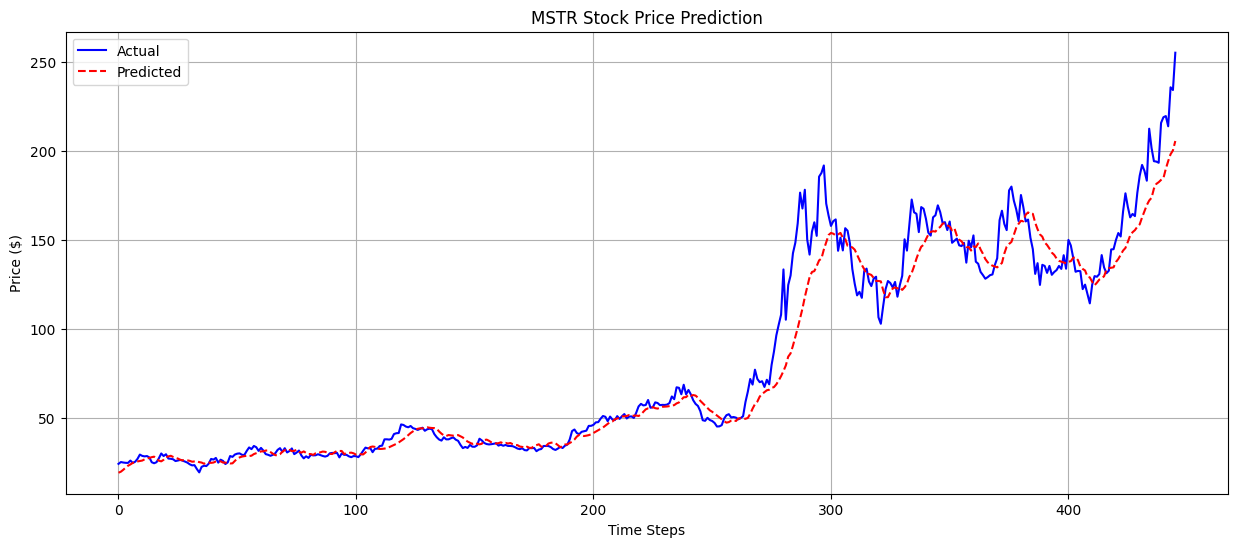


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 10.5074
RMSE: 3.2415
MAE: 2.5067


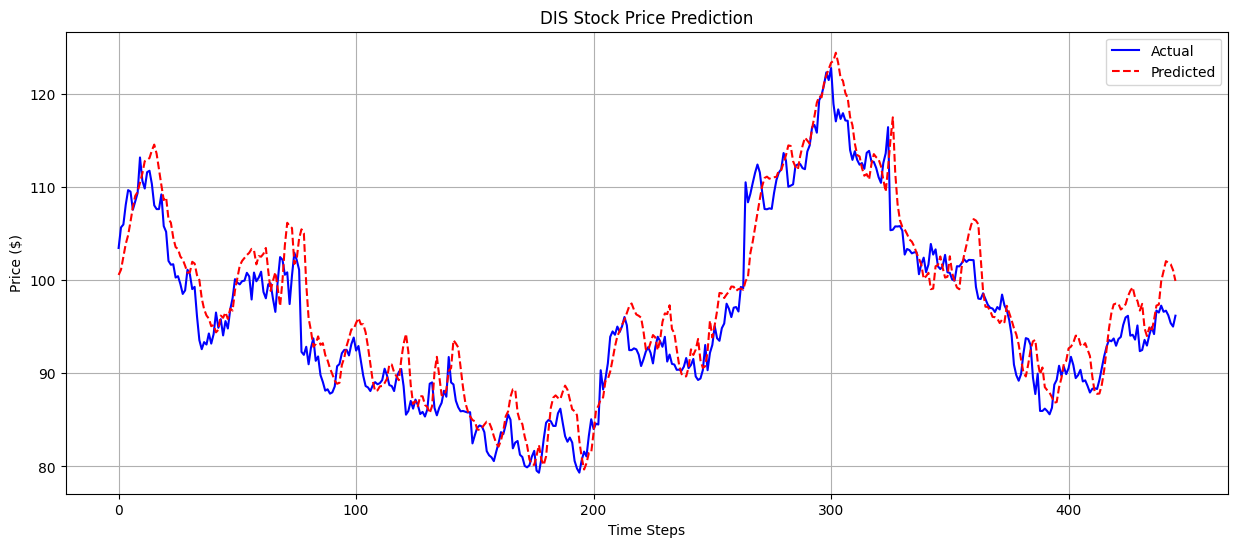


Analyzing BA...

Evaluation Metrics for BA:
MSE: 50.3953
RMSE: 7.0990
MAE: 5.2800


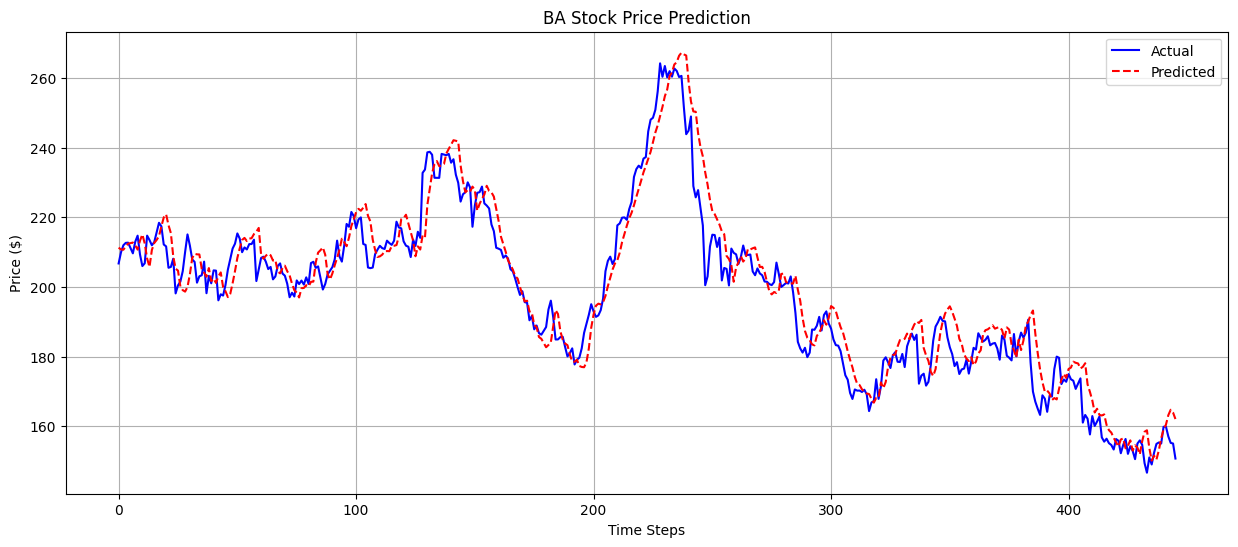


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 12.8787
RMSE: 3.5887
MAE: 2.9235


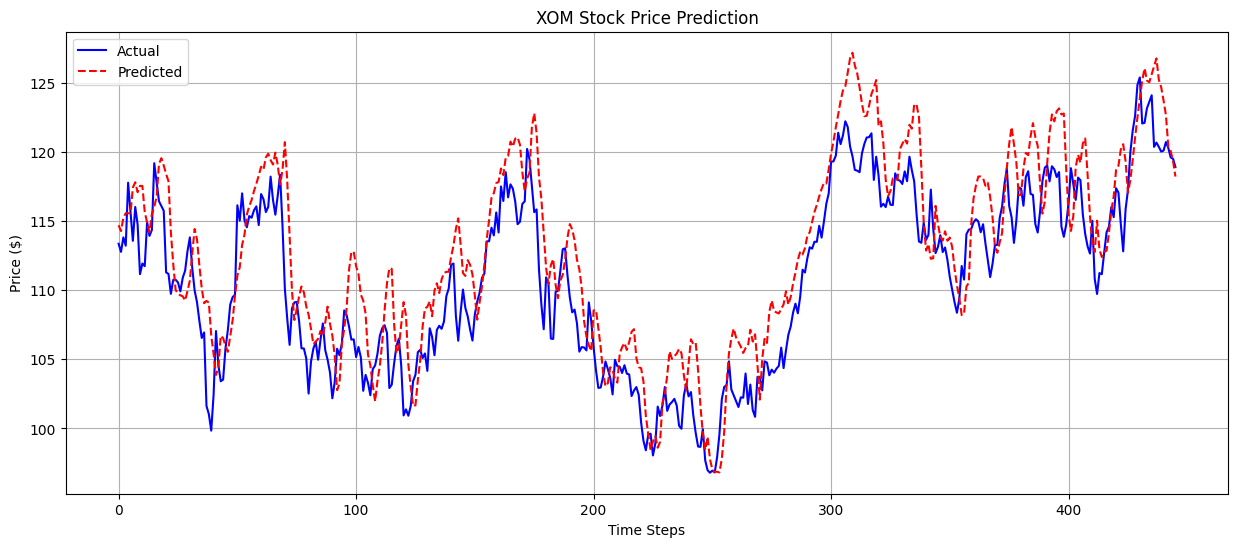


Analyzing ORCL...

Evaluation Metrics for ORCL:
MSE: 17.0001
RMSE: 4.1231
MAE: 3.0758


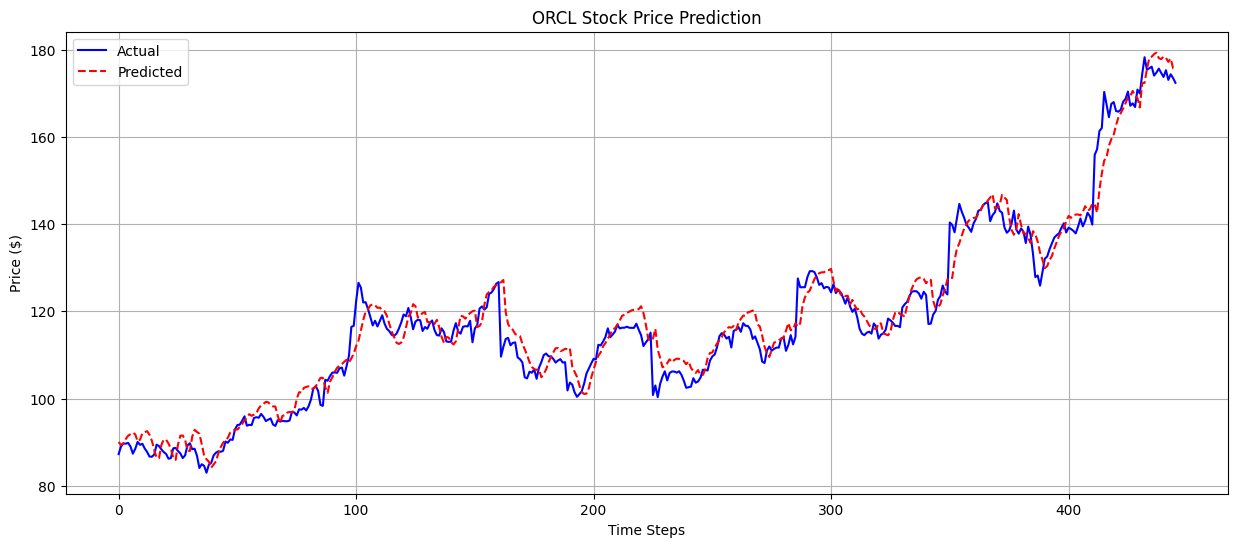


Analyzing META...

Evaluation Metrics for META:
MSE: 520.4387
RMSE: 22.8131
MAE: 16.5263


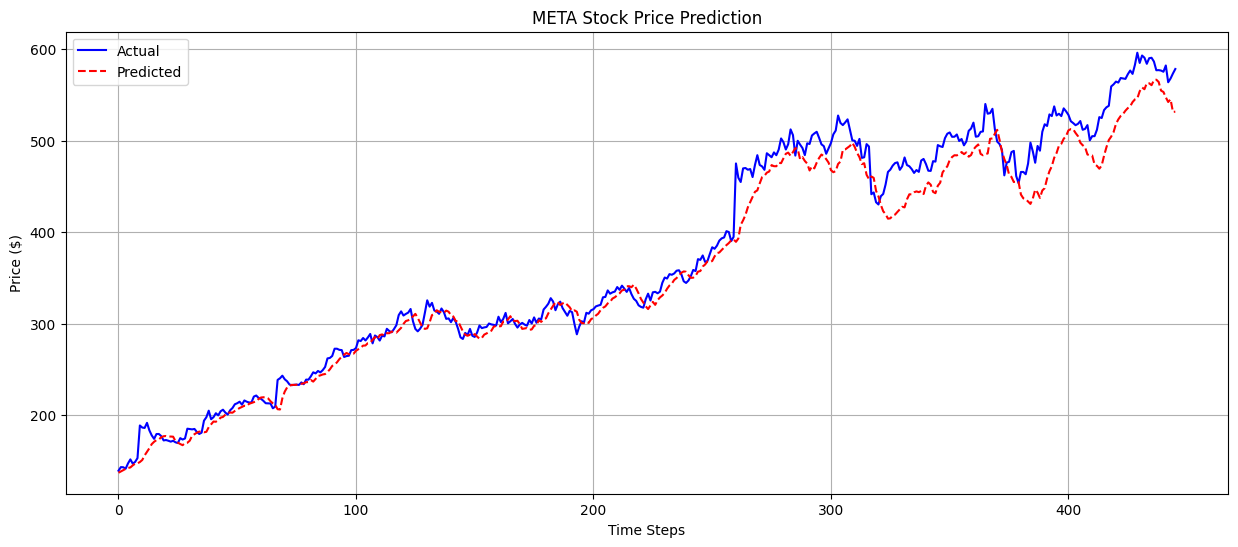


Summary of Metrics for All Stocks:
               MSE       RMSE        MAE
AAPL     25.571353   5.056813   4.103085
AMZN     20.524659   4.530415   3.537402
GME       9.217968   3.036111   1.918899
GOOGL    16.277536   4.034543   3.112978
NFLX   1306.353992  36.143519  29.319907
TSLA    190.892823  13.816397  10.454604
MSFT    150.509386  12.268227   9.571649
NVDA     18.396150   4.289073   2.973669
AMD      50.233436   7.087555   5.258681
CRM      58.473215   7.646778   5.610932
JPM      21.460490   4.632547   3.760937
V        44.491505   6.670195   5.569606
MA      235.207569  15.336478  12.295578
MSTR    186.538239  13.657900   7.813058
DIS      10.507400   3.241512   2.506654
BA       50.395306   7.098965   5.280038
XOM      12.878683   3.588688   2.923467
ORCL     17.000068   4.123114   3.075822
META    520.438739  22.813126  16.526317
time: 10.5 s (started: 2024-11-21 14:09:40 +00:00)


In [12]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 'BA', 'XOM', 'ORCL', 'META']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_model_performance(model, val_X, val_y, scaler, n_steps_out):
    """
    Evaluate the LSTM model's performance on validation data.
    
    Args:
        model: Trained LSTM model
        val_X: Validation input sequences
        val_y: Validation target sequences
        scaler: Global MinMaxScaler used for inverse transformation
        n_steps_out: Number of output steps
    
    Returns:
        dict: Performance metrics and predictions
    """
    # Make predictions
    val_predictions = model.predict(val_X)
    
    # Function to safely inverse transform a single sequence
    def inverse_transform_sequence(original_features, model_predictions, actual_target):
        """
        Inverse transform predictions with careful handling of feature dimensions
        
        Args:
            original_features: Input features sequence
            model_predictions: Model's predicted values
            actual_target: Actual target values for comparison
        
        Returns:
            Inverse transformed predictions
        """
        # Get the number of original features (excluding target)
        n_original_features = original_features.shape[1]
        
        # Prepare a placeholder for combined data
        combined_data = np.zeros((n_steps_out, n_original_features + 1))
        
        # Fill in the original features (use the last input features)
        combined_data[:, :n_original_features] = original_features[-1, :n_original_features]
        
        # Add predictions in the last column
        combined_data[:, -1] = model_predictions
        
        # Inverse transform
        inv_transformed = scaler.inverse_transform(combined_data)
        
        # Return only the last column (predictions)
        return inv_transformed[:, -1]
    
    # Prepare lists to store results
    all_predictions_inv = []
    all_actual_inv = []
    
    # Process multiple stocks/sequences
    for i in range(val_predictions.shape[0]):
        # Inverse transform predictions for this sequence
        pred_inv = inverse_transform_sequence(
            original_features=val_X[i], 
            model_predictions=val_predictions[i], 
            actual_target=val_y[i]
        )
        
        actual_inv = inverse_transform_sequence(
            original_features=val_X[i], 
            model_predictions=val_y[i], 
            actual_target=val_y[i]
        )
        
        all_predictions_inv.append(pred_inv)
        all_actual_inv.append(actual_inv)
    
    # Convert to numpy arrays
    all_predictions_inv = np.array(all_predictions_inv)
    all_actual_inv = np.array(all_actual_inv)
    
    # Flatten for metrics calculation
    flat_predictions = all_predictions_inv.flatten()
    flat_actual = all_actual_inv.flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(flat_actual, flat_predictions)
    mse = mean_squared_error(flat_actual, flat_predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(flat_actual, flat_predictions)
    
    metrics = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Percentage Error': mape * 100  # Convert to percentage
    }
    
    return {
        'metrics': metrics,
        'predictions': all_predictions_inv,
        'actual': all_actual_inv
    }

def plot_prediction_results(evaluation_results, save_path='stock_prediction_results.png'):
    """
    Create visualizations of model predictions vs actual values.
    
    Args:
        evaluation_results: Dictionary containing predictions and actual values
        save_path: Path to save the plot
    """
    # Determine number of stocks/subplots
    n_stocks = len(evaluation_results['predictions'])
    
    # Create subplots
    fig, axs = plt.subplots(n_stocks, 1, figsize=(12, 4*n_stocks), sharex=True)
    
    # Ensure axs is always a list, even if only one stock
    if n_stocks == 1:
        axs = [axs]
    
    # Plot for each stock
    for i in range(n_stocks):
        predictions = evaluation_results['predictions'][i]
        actual = evaluation_results['actual'][i]
        
        axs[i].plot(range(len(actual)), actual, 
                    label='Actual Values', color='blue', marker='o')
        axs[i].plot(range(len(predictions)), predictions, 
                    label='Predicted Values', color='red', marker='x')
        
        axs[i].set_title(f'Stock {i+1}: Price Prediction')
        axs[i].set_ylabel('Stock Price')
        axs[i].legend()
        axs[i].grid(True)
    
    # Only set xlabel for the bottom subplot
    axs[-1].set_xlabel('Time Steps')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def plot_training_history(history, save_path='training_history.png'):
    """
    Visualize the training and validation loss over epochs.
    
    Args:
        history: Model training history
        save_path: Path to save the plot
    """
    plt.figure(figsize=(12, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def run_model_evaluation(model, val_X, val_y, scaler, history, n_steps_out):
    """
    Comprehensive model evaluation workflow.
    
    Args:
        model: Trained LSTM model
        val_X: Validation input sequences
        val_y: Validation target sequences
        scaler: Global MinMaxScaler used for inverse transformation
        history: Model training history
        n_steps_out: Number of output steps
    """
    # Evaluate model performance
    evaluation_results = evaluate_model_performance(model, val_X, val_y, scaler, n_steps_out)
    
    # Print metrics
    print("Model Performance Metrics:")
    for metric, value in evaluation_results['metrics'].items():
        print(f"{metric}: {value}")
    
    # Plot prediction results
    plot_prediction_results(evaluation_results)
    
    # Plot training history
    plot_training_history(history)
    
    return evaluation_results

# Run the evaluation (adjust n_steps_out to match your model configuration)
evaluation_results = run_model_evaluation(model, val_X, val_y, scaler, history, n_steps_out=n_steps_out)

# Optional: Print first few predictions for verification
print("\nSample Predictions:")
for i, (pred, actual) in enumerate(zip(evaluation_results['predictions'], evaluation_results['actual']), 1):
    print(f"\nStock {i}:")
    print("Predicted:", pred)
    print("Actual:   ", actual)

265/265 [==============================] - 2s 8ms/step
Model Performance Metrics:
Mean Absolute Error: 7.916720942585985
Mean Squared Error: 163.2661423403403
Root Mean Squared Error: 12.777564022157756
Mean Absolute Percentage Error: 4.523169360334375


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7efedd5339c0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1200x3389600 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1200x3389600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x3.3896e+06 with 2953 Axes>

time: 2min 8s (started: 2024-11-21 14:09:51 +00:00)
